<center><font size="5"><b>ChBE 6745 Project: Jupyter Notebook for final report</b></font></center>

---

<center><font size="5"><b>Prediction of Adsorption Properties of Metal-Organic Frameworks with Framework Flexibility</b></font></center>

---

<center><b>Chao-Wen Chang, Pengfei Cheng, Po-Wei Huang, Xiaohan Yu, Yamin Zhang</b></center>

This Jupyter notebook file covers the codes that were used to generate the results in the final report.
General explanations can be found in the corresponding section in the report for most parts; 
extra explanations are given here in the paragraph blocks and comments for the rest. 

# Preliminaries

This section contains the codes for
- preprocessing the datasets to generate "$X$" and "$y$" as two `numpy.array`'s in Python,
- preliminary visualization of predicted uptake values.

## Data preprocessing

In [1]:
# Preamble for package import and figure formatting

import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Lasso
from sklearn.linear_model import LinearRegression
from sklearn.kernel_ridge import KernelRidge
from sklearn.neural_network import MLPRegressor
from sklearn.metrics.pairwise import rbf_kernel

from IPython.display import set_matplotlib_formats
set_matplotlib_formats('pdf', 'png')
plt.rcParams['savefig.dpi'] = 300
plt.rcParams['figure.autolayout'] = False
plt.rcParams['figure.figsize'] = 12, 8
plt.rcParams['axes.labelsize'] = 18
plt.rcParams['axes.titlesize'] = 20
plt.rcParams['font.size'] = 16
plt.rcParams['lines.linewidth'] = 2.0
plt.rcParams['lines.markersize'] = 4
plt.rcParams['legend.fontsize'] = 14
plt.rcParams['font.family'] = "serif"
plt.rcParams['font.serif'] = "cm"
plt.rcParams['text.usetex'] = True
plt.rcParams['text.latex.preamble']= r"\usepackage{subdepth}, \usepackage{type1cm}"

from warnings import filterwarnings
filterwarnings('ignore')

from copy import deepcopy

### Read MOF features

In [2]:
# read MOF feature data

df36Descriptor = pd.read_excel('data/ML_data/descriptor_used.xlsx',header=4,index_col=1)

# clean up the column
columns = [df36Descriptor.columns[1]] + df36Descriptor.columns[3: -11].tolist()

newColumns = {}
for ci in columns:
    if ' ' in ci:
        newColumns[ci] = ci.split(' ',1)[0]
    elif '(' in ci:
        newColumns[ci] = ci.split('(',1)[0]
    else:
        newColumns[ci] = ci

dfShortNames = df36Descriptor[columns].rename(columns=newColumns)

# reduce columns to only contain MOF features
shared_descriptor = [col for col in dfShortNames.columns if col in newColumns]
dfMLReduced = dfShortNames[shared_descriptor]

### Read adsorption update data

In [3]:
# Read adsorption update data

# the MOFs in "dfMLReduced" and adsorption data sets are different, so it is necessary to match the MOFs in two datasets
def datasetMatch(MOFName):
    dfML= dfMLReduced[dfMLReduced['MOF'].isin(MOFName)].drop_duplicates()
    matchedMOFIndex=np.isin(MOFName, dfML['MOF'].values)
    return matchedMOFIndex, dfML

# read flexibility data
flexibilityList=os.listdir('data/flexibility_data/y_data/adsorption_data') # obtain list of csv files for 9 adsorption uptakes
flexivilityData=[]
adsorbateNameList = []

for i, name in enumerate(flexibilityList):
    # read csv files for certain adsorption uptakes
    df = pd.read_csv('data/flexibility_data/y_data/adsorption_data/' + name)
    
    # obtain the rigid value
    rigidValue = np.array(df[df.columns[1]], dtype = float)
    
    # obtain the flexible mean value
    flexValue = np.mean(np.array(df[df.columns[2:]],dtype=float),axis=1)
    
    # obtain the adsorbate label
    label = np.array([name.split("_")[1] for x in range(0,len(flexValue))],dtype=str)
    adsorbateNameList.append(name.split("_")[1])
    
    # stack the rigid value, flexible mean value and the adsorbate label
    singleSet = np.column_stack([rigidValue,flexValue,label])

    if i == 0:
        # obtain the name list of MOFs
        MOFNameTemp = np.array(df[df.columns[0]], dtype = str)
        MOFName = [x.split("_")[0] for x in MOFNameTemp]
        
        # search the MOF name in "dfMLReduced", generating dfML
        matchedMOFIndex, dfML = datasetMatch(MOFName)
        
        # generating flexibilityData as "y"
        flexibilityData = singleSet[matchedMOFIndex,:].copy()
    else:
        # concatenate "y"
        flexibilityData = np.concatenate([flexibilityData.copy(),singleSet[matchedMOFIndex,:].copy()])

### Manually add adsorbate features

In [4]:
# manually add adsorbate descriptors

# units of features: Mw/gr.mol-1, Tc/K, Pc/bar, ω, Tb/K, Tf/K

adsorbateData=np.array([
    ['xenon',131.293,289.7,58.4,0.008,164.87,161.2], 
    ['butane',58.1,449.8,39.5,0.3,280.1,146.7], 
    ['propene',42.1,436.9,51.7,0.2,254.8,150.6], 
    ['ethane',30.1,381.8,50.3,0.2,184.0,126.2], 
    ['propane',44.1,416.5,44.6,0.2,230.1,136.5], 
    ['CO2',44.0,295.9,71.8,0.2,317.4,204.9], 
    ['ethene',28.054,282.5,51.2,0.089,169.3,228], 
    ['methane',16.04,190.4,46.0,0.011,111.5,91],
    ['krypton',83.798,209.4,55.0,0.005,119.6,115.6]])

adDf = pd.DataFrame(data=adsorbateData, columns=["adsorbate", "Mw/gr.mol-1", "Tc/K", "Pc/bar", "ω", "Tb/K", "Tf/K"])

# sort the dataframe based on adsorbateNameList
sorterIndex = dict(zip(adsorbateNameList,range(len(adsorbateNameList))))
adDf['an_Rank'] = adDf['adsorbate'].map(sorterIndex)
adDf.sort_values(['an_Rank'],ascending = [True], inplace = True)
adDf.drop('an_Rank', 1, inplace = True)
adDfFloat = adDf.iloc[:, 1:].astype(np.float)
adDfFloat["adsorbate"] = adDf["adsorbate"]

### Combine MOF and adsorbate descriptors

In [5]:
## Combine MOF and adsorbate feature data

# replicate dfML for 9 adsorbates
dfMLReplicate = pd.concat([dfML]*9)

# replicate adDf for 89 MOFs
adDfReplicate = pd.DataFrame(np.repeat(adDfFloat.values, 89, axis=0))
adDfReplicate.columns = adDfFloat.columns

# concatenate two datasets
dfMLReplicate.reset_index(drop=True, inplace=True)
adDfReplicate.reset_index(drop=True, inplace=True)
XAllDescriptor = pd.concat([dfMLReplicate, adDfReplicate],axis=1)

### Generate X and y

In [6]:
# generate X and y

X = np.concatenate((XAllDescriptor.iloc[:, 1:-1], flexibilityData[:, 0].astype('float64').reshape(-1, 1)),axis=1).astype(np.float)
y = flexibilityData[:, 1].astype('float64').reshape(-1,1)

## Visualization of output values

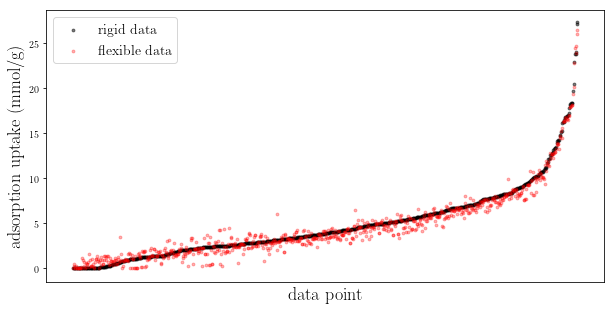

In [7]:
y_plot_flex = flexibilityData[:, 1].astype('float64')
y_plot_rigid = flexibilityData[:, 0].astype('float64')

sort_index = np.argsort(y_plot_rigid)

y_plot_flex_sorted = y_plot_flex[sort_index]
y_plot_rigid_sorted = y_plot_rigid[sort_index]

fig, ax = plt.subplots(figsize=(10, 5))

x_ticks = list(range(y_plot_rigid_sorted.size))
ax.scatter(x_ticks, y_plot_rigid_sorted, alpha=0.5, color='k', label='rigid data', s=8)
ax.scatter(x_ticks, y_plot_flex_sorted, alpha=0.3, color='r', label='flexible data', s=8)

# ax.set_xticklabels([])
# ax.axes.get_xaxis().set_visible(False)
ax.set_xticks([])
ax.set_ylabel("adsorption uptake (mmol/g)")
ax.set_xlabel("data point")
ax.legend()

# Validation strategy

## Hold-out for validation set

In [8]:
np.random.seed(5)

# generate validation set
X_train_test, X_validation, y_train_test, y_validation = train_test_split(X, y, test_size=0.25)

## 5-Fold for model training

We utilize the feature of `GridSearchCV` applying the same CV-splitter object `kf` for all models for training and hyperparameter optimization, which is defined below.

In [9]:
# create a CV-splitter object that is used for all models
kf = KFold(n_splits=5, shuffle = True, random_state=20)

# for models that cannot use kf, explicit (train, test) pairs are created
for i, (train_index, test_index) in enumerate(kf.split(X_train_test)):
    
    # initialize sets
    if i == 0:
        X_train_5fold = np.zeros(X_train_test[train_index].shape + (5,))
        X_test_5fold = np.zeros(X_train_test[test_index].shape + (5,))
        y_train_5fold = np.zeros(y_train_test[train_index].shape + (5,))
        y_test_5fold = np.zeros(y_train_test[test_index].shape + (5,))
    
    X_train_5fold[:, :, i], X_test_5fold[:, :, i] = X_train_test[train_index], X_train_test[test_index]
    y_train_5fold[:, :, i], y_test_5fold[:, :, i] = y_train_test[train_index], y_train_test[test_index]

## Feature scaling
The feature scaling section is after the cross validation part to make sure that the scaling is based on the mean values and standard deviations of only the training-test data, so that the scaled data are not contaminated by the validation data.

### Summary statistics

Text(0, 0.5, 'standard deviation')

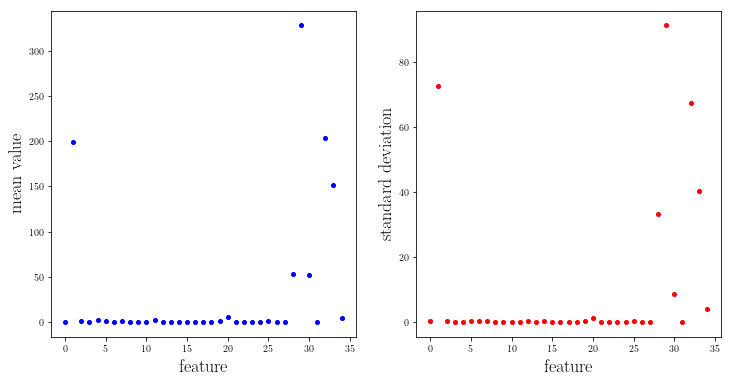

In [10]:
X_avg = X.mean(axis=0)
X_std = X.std(axis=0)

fig, axes = plt.subplots(1, 2, figsize=(12, 6))
axes[0].scatter(list(range(X_avg.size)), X_avg, color='b')
axes[0].set_xlabel("feature")
axes[0].set_ylabel("mean value")

axes[1].scatter(list(range(X_avg.size)), X_std, color='r')
axes[1].set_xlabel("feature")
axes[1].set_ylabel("standard deviation")

The scatter plots above show that features have different scales of mean values and standard deviation, indicating that it is necessary to scale the features before further modeling.

### Standard scaling using training-test data

In [11]:
X_train_test_scaled = (X_train_test - X_train_test.mean(axis=0))/X_train_test.std(axis=0) 
X_validation_scaled = (X_validation - X_train_test.mean(axis=0))/X_train_test.std(axis=0) 

X_train_scaled_5fold = np.zeros(X_train_5fold.shape)
X_test_scaled_5fold = np.zeros(X_test_5fold.shape)

for i in range(5):
    X_train_scaled_5fold[:, :, i] = (X_train_5fold[:, :, i] - X_train_test.mean(axis=0))/X_train_test.std(axis=0)
    X_test_scaled_5fold[:, :, i] = (X_test_5fold[:, :, i] - X_train_test.mean(axis=0))/X_train_test.std(axis=0)

# Multi-linear regression

In [12]:
def MLR(X_train, y_train, X_test, y_test, print_r2=False):
    
    r2_best = 0
    LR_model = LinearRegression()

    # Manually apply 5-fold
    for i in range(5):
        
        LR_model.fit(X_train[:, :, i], y_train[:, :, i])
        
        r2_temp = LR_model.score(X_test[:, :, i], y_test[:, :, i])
        
        if r2_temp > r2_best:
            LR_model_best = deepcopy(LR_model)
            r2_best = r2_temp
        
    if print_r2 == True:
        print("{:>45}training r2 = {:.3f}".format("", r2_best))
        
    return LR_model_best

# RBF kernel regression (without regularization)

Since pure RBF kernel regression model cannot directly apply `GridSearchCV`, we manually apply hyperparameter tuning using for-loops. 
We basically follow the general hyperparameter tuning strategy described in the report. 
After the best $\gamma$ is obtained in the rough estimation for a certain fold, we directly apply refined estimation in that certain fold.
The pure RBF kernel model is trained on both the unscaled data and the scaled data.

In [13]:
def RBF_wo_regularization(X_train, y_train, X_test, y_test, sigmas, print_r2=False):

    gammas = 1./(2*sigmas**2)
    model_rbf = LinearRegression()
    r2_best = 0

    # rough estimation of gamma 
    # manually apply 5-fold
    for i in range(5):

        for j, gamma in enumerate(gammas):

            X_train_kernel = rbf_kernel(X_train[:, :, i], X_train[:, :, i], gamma = gamma)
            X_test_kernel = rbf_kernel(X_test[:, :, i], X_train[:, :, i], gamma = gamma)
            model_rbf.fit(X_train_kernel, y_train[:, :, i])

            r2_temp = model_rbf.score(X_test_kernel, y_test[:, :, i])

            if r2_temp > r2_best:
                r2_best = r2_temp
                model_rbf_best = deepcopy(model_rbf)
                best_fold = i
                best_gamma = gamma
        
    # refined estimation of gamma 
    
    refined_gammmas = np.append(np.logspace(np.log(best_gamma) - 1, np.log(best_gamma) + 1, 10), best_gamma)
    
    for j, gamma in enumerate(refined_gammmas):

            X_train_kernel = rbf_kernel(X_train[:, :, best_fold], X_train[:, :, best_fold], gamma = gamma)
            X_test_kernel = rbf_kernel(X_test[:, :, best_fold], X_train[:, :, best_fold], gamma = gamma)
            model_rbf.fit(X_train_kernel, y_train[:, :, best_fold])

            r2_temp = model_rbf.score(X_test_kernel, y_test[:, :, best_fold])

            if r2_temp > r2_best:
                r2_best = r2_temp
                model_rbf_best = deepcopy(model_rbf)
                best_gamma = gamma
    
    if print_r2 == True:
        print("{:>45}training r2 = {:.3f}".format("", r2_best))
    
    return model_rbf_best, best_fold, best_gamma

# Kernel ridge regression (KRR)

In [14]:
def KRR(X_train_test, y_train_test, sigmas, alphas, print_r2=False):
    
    gammas = 1./(2*sigmas**2)
    parameter_ranges = {'alpha':alphas, 'gamma':gammas}
    
    model_KRR = KernelRidge(kernel='rbf')
    
    # rough estimation
    model_KRR_search = GridSearchCV(model_KRR, parameter_ranges, cv=kf)
    model_KRR_search.fit(X_train_test, y_train_test)
    
    # refined estimation
    gamma_rough_best = model_KRR_search.best_estimator_.gamma
    alpha_rough_best = model_KRR_search.best_estimator_.alpha
    refined_gammmas = np.append(np.logspace(np.log(gamma_rough_best) - 1, np.log(gamma_rough_best) + 1, 10), gamma_rough_best)
    refined_alphas = np.append(np.logspace(np.log(alpha_rough_best) - 1, np.log(alpha_rough_best) + 1, 10), alpha_rough_best)
    parameter_ranges_refined = {'alpha':refined_alphas, 'gamma':refined_gammmas}
    
    model_KRR_search = GridSearchCV(model_KRR, parameter_ranges, cv=kf)
    model_KRR_search.fit(X_train_test, y_train_test)
    
    if print_r2 == True:
        print("{:>45}training r2 = {:.3f}".format("", model_KRR_search.best_score_))
    
    return model_KRR_search.best_estimator_

# LASSO regression

Despite the fact that our multi-linear model works very well, overfitting may still be a big issue. 
Parameter regularization is therefore an effectively way to avoid such complexity.

Herein, we introduce Lasso Regression based on the follow reasons:
1. to resolve the overfitting issue in the RBF kernel regression model, and 
2. to simplify the models by dropping some unimportant features. 

Because our multi-linear model has very good performance, the first part is to combine LASSO regularization with multi-linear model which has 35 features. 
The second part is to combine LASSO regularization with RBF kernel model to see if Lasso regression improves its poor performance in our baseline model.

## LASSO-multi-linear regression

In [15]:
def LASSO(X_train_test, y_train_test, alphas, tol=1e-2, print_r2=False):
    parameter_set = {'alpha':alphas}
    
    model_LASSO = Lasso(tol=tol, max_iter=500)
    model_LASSO_search = GridSearchCV(model_LASSO, parameter_set, cv=kf)
    model_LASSO_search.fit(X_train_test, y_train_test)
    
    alpha_rough_best = model_LASSO_search.best_estimator_.alpha
    
    refined_alphas = np.append(np.logspace(np.log(alpha_rough_best) - 1, np.log(alpha_rough_best) + 1, 10), alpha_rough_best)
    
    model_LASSO_search_refined = GridSearchCV(model_LASSO, {'alpha':refined_alphas}, cv=kf)
    model_LASSO_search_refined.fit(X_train_test, y_train_test)
    
    if print_r2 == True:
        print("{:>45}training r2 = {:.3f}".format("", model_LASSO_search_refined.best_score_))
    
    return model_LASSO_search_refined.best_estimator_

## LASSO-RBF-kernel regression

Similar to the original RBF kernel regression model, the LASSO-RBF-kernel model needs to manually apply the 5-Fold cross validation for hyperparameter tuning to guarantee that the result will be least biased.
However it would lead to numerical errors during model training.
Here we directly use `GridSearchCV` that may lead the models to be biased to some degree by the different split of training-test data.

In [16]:
def LASSO_RBF(X_train_test, y_train_test, sigmas, alphas, print_r2=False):
    
    gammas = 1./(2*sigmas**2)
    parameter_set = {'alpha':alphas}
    
    model_LASSO_RBF = Lasso(tol=1)
    
    r2_best = 0
    
    for j, gamma in enumerate(gammas):
    
        X_train_test_kernel = rbf_kernel(X_train_test, X_train_test, gamma = gamma)
        model_LASSO_RBF_search = GridSearchCV(model_LASSO_RBF, parameter_set, cv=kf)
        model_LASSO_RBF_search.fit(X_train_test_kernel, y_train_test)
        
        if model_LASSO_RBF_search.best_score_ > r2_best:
            model_LASSO_RBF = deepcopy(model_LASSO_RBF_search.best_estimator_)
            r2_best = model_LASSO_RBF_search.best_score_
            gamma_best = gamma

    alpha_rough_best = model_LASSO_RBF.alpha
    
    refined_gammmas = np.append(np.logspace(np.log(gamma_best) - 1, np.log(gamma_best) + 1, 10), gamma_best)
    refined_alphas = np.append(np.logspace(np.log(alpha_rough_best) - 1, np.log(alpha_rough_best) + 1, 10), alpha_rough_best)
    
    parameter_set_refined = [{'alpha':refined_alphas}]

    for j, gamma in enumerate(refined_gammmas):

        X_train_test_kernel = rbf_kernel(X_train_test, X_train_test, gamma = gamma)
        model_LASSO_RBF_search = GridSearchCV(model_LASSO_RBF, parameter_set_refined, cv=kf)
        model_LASSO_RBF_search.fit(X_train_test_kernel, y_train_test)
        
        if model_LASSO_RBF_search.best_score_ > r2_best:
            model_LASSO_RBF = deepcopy(model_LASSO_RBF_search)
            r2_best = model_LASSO_RBF_search.best_score_
            gamma_best = gamma
            
    if print_r2 == True:
        print("{:>45}training r2 = {:.3f}".format("", r2_best))
    
    return model_LASSO_RBF, gamma_best

# MLPRegressor (neural network)

Neural network (NN) is a powerful set of algorithms inspired by human brains.
As mentioned in the class, perceptron classifier model can be seen as a single layer NN classifier model, and NN models can be seen as multi-layer perceptron models by applying the logistic or ReLU functions several times on the perceptron model outputs.
They are good at nonlinear data processing and are used extensively in many fields, such as image processing, natural language processing and forecasting.

<img src="images/NN.png" width="600">

Here we intend to apply one of NN regression models on our project to:

1. learn the mechanism of NN models, which hyperparameters they have, and how to tune them, and
2. briefly compare NN prediction results with other prediction models covered in the class.

The NN model that we use is `MLPRegressor` in `sklearn`, where `MLP` means multi-layer Perceptron.
It is capable of processing nonlinear data, but it has a nonconvex loss function, which makes it hard to find the global optimum.
It also involves a number of hyperparameters, such as the number of hidden neurons and layers.
The focus of this section is to finely tuning the hyperparameters of `MLPRegressor` to try to obtain a NN model with improved prediction ability.

## Hyperparameter tuning strategy

There are three main types of hyperparameters:

2. the number of hidden layers ($L \in \mathbb{N}$),
1. the number of hidden neurons ($n_l \in \mathbb{N}, l \in \{1,2,...,L\}$), and
3. activation function types (Logistic function or Rectified Linear Unit (ReLU) function).

$$\mathcal{L}_\text{logistic} (x) = \max(0, x) $$

$$\mathcal{L}_\text{ReLU} (x) = \ln (1 + e^{-x}) $$

The number of parameters in the model grows linearly with $n_l$ and exponentially with $L$.
Therefore, it may be computationally expensive to simultaneously tune $n_l$ and $L$.
An alternative way is to first tune $n_1$ for a single-layer NN model, then fix $n_1$ and tune $n_2$ and so on.
So we propose to tune the hyperparameter for the NN model using the alternative way
while limiting the upper bound of $n_i$ to 100 and $L$ to 3.
The tuning process will be conducted twice with Logistic and ReLu as loss functions respectively.

Also for MLPRegressor only the scaled data is used, as unscaled data may cause some error during training.

## Hyperparameter tuning for MLPRegressor
### Tuning for 1-layer model
First a rough value list of $n_1$ is searched through:

In [17]:
def NN_1(X_train_test=X_train_test, y_train_test=y_train_test, n_UBD=100, activation_fun='logistic', print_r2=False):
    
    layer_list_n1 = [1] + list(range(10, n_UBD + 10, 10))
    layer_dict_n1 = {
        'hidden_layer_sizes': layer_list_n1
    }
    
    model_NN_1 = MLPRegressor(max_iter=500, activation=activation_fun)
    
    model_NN_1_search = GridSearchCV(model_NN_1, layer_dict_n1, n_jobs=-1, cv=kf)
    model_NN_1_search.fit(X_train_test, y_train_test.ravel())
    model_NN_1_best = model_NN_1_search.best_estimator_
    
    layer_list_n1_refined = list(range(max(model_NN_1_best.hidden_layer_sizes - 10, 1), min(102, model_NN_1_best.hidden_layer_sizes + 10), 2))
    layer_dict_n1_refined = {
        'hidden_layer_sizes': layer_list_n1_refined
    }
    model_NN_1_refined = MLPRegressor(max_iter=500, activation=activation_fun)
    model_NN_1_refined_search = GridSearchCV(model_NN_1_refined, layer_dict_n1_refined, n_jobs=-1, cv=kf)
    model_NN_1_refined_search.fit(X_train_test, y_train_test.ravel())
    logistic_NN_1_refined_best = model_NN_1_refined_search.best_estimator_
    best_n1 = logistic_NN_1_refined_best.hidden_layer_sizes
    
    if print_r2 == True:
        print("{:>45}training r2 = {:.3f}".format("", model_NN_1_refined_search.best_score_))
    
    return logistic_NN_1_refined_best, best_n1

### Tuning for 2-layer model
Denote $n_1^*$ as the optimal value for the number of neurons for the first layer.
A list of 2-tuples is defined as the search space for the 2-layer NN model.
The first element is fixed at $n_1^*$, the second element varies from 1 to 100.

In [18]:
def NN_2(best_n1, X_train_test=X_train_test, y_train_test=y_train_test, n_UBD=100, activation_fun='logistic', print_r2=False):
    
    list_temp = [1] + list(range(10, 110, 10))

    layer_list_n2 = []
    for i in list_temp:
        layer_list_n2.append((best_n1, i))
    layer_dict_n2 = {
        'hidden_layer_sizes': layer_list_n2
    }
    
    model_NN_2 = MLPRegressor(max_iter=500, activation=activation_fun)
    
    model_NN_2_search = GridSearchCV(model_NN_2, layer_dict_n2, n_jobs=-1, cv=kf)
    model_NN_2_search.fit(X_train_test, y_train_test.ravel())
    model_NN_2_best = model_NN_2_search.best_estimator_
    
    list_temp = list(range(max(model_NN_2_best.hidden_layer_sizes[1] - 10, 1), min(102,model_NN_2_best.hidden_layer_sizes[1] + 10), 2))

    layer_list_n2_refined = []
    for i in list_temp:
        layer_list_n2_refined.append((best_n1, i))
    layer_dict_n2_refined = {
        'hidden_layer_sizes': layer_list_n2_refined
    }
    
    model_NN_2_refined = MLPRegressor(max_iter=500, activation=activation_fun)
    model_NN_2_refined_search = GridSearchCV(model_NN_2_refined, layer_dict_n2_refined, n_jobs=-1, cv=kf)
    model_NN_2_refined_search.fit(X_train_test, y_train_test.ravel())
    logistic_NN_2_refined_best = model_NN_2_refined_search.best_estimator_
    best_n2 = logistic_NN_2_refined_best.hidden_layer_sizes
    
    if print_r2 == True:
        print("{:>45}training r2 = {:.3f}".format("", model_NN_2_refined_search.best_score_))
    
    return logistic_NN_2_refined_best, best_n2

### Tuning for 3-layer model
$n_3$ is tuned in a similar manner:

In [19]:
def NN_3(best_n1, best_n2, X_train_test=X_train_test, y_train_test=y_train_test, n_UBD=100, activation_fun='logistic', print_r2=False):
    
    list_temp = [1] + list(range(10, 110, 10))

    layer_list_n3 = []
    for i in list_temp:
        layer_list_n3.append((best_n1, best_n2[1], i))

    layer_dict_n3 = {
        'hidden_layer_sizes': layer_list_n3
    }

    model_NN_3 = MLPRegressor(max_iter=500, activation=activation_fun)
    model_NN_3_search = GridSearchCV(model_NN_3, layer_dict_n3, n_jobs=-1, cv=kf)
    model_NN_3_search.fit(X_train_test, y_train_test.ravel())
    model_NN_3_best = model_NN_3_search.best_estimator_
    
    list_temp = list(range(max(2, model_NN_3_best.hidden_layer_sizes[2] - 10), min(100, model_NN_3_best.hidden_layer_sizes[2] + 10), 2))
    layer_list_n3_refined = []
    for i in list_temp:
        layer_list_n3_refined.append((best_n1, best_n2[1], i))
        
    layer_dict_n3_refined = {
        'hidden_layer_sizes': layer_list_n3_refined
    }

    model_NN_3_refined = MLPRegressor(max_iter=500, activation=activation_fun)
    model_NN_3_refined_search = GridSearchCV(model_NN_3_refined, layer_dict_n3_refined, n_jobs=-1, cv=kf)
    model_NN_3_refined_search.fit(X_train_test, y_train_test.ravel())
    logistic_NN_3_refined_best = model_NN_3_refined_search.best_estimator_
    
    if print_r2 == True:
        print("{:>45}training r2 = {:.3f}".format("", model_NN_3_refined_search.best_score_))
    
    return logistic_NN_3_refined_best

# Model comparison

## Training time

### Multilinear regression

In [20]:
print("Training time of {:<30} with {:<15}".format("Multi-linear regression", "unscaled data"))
%timeit -n 10 MLR(X_train_5fold, y_train_5fold, X_test_5fold, y_test_5fold)

print("Training time of {:<30} with {:<15}".format("Multi-linear regression", "scaled data"))
%timeit -n 10 MLR(X_train_scaled_5fold, y_train_5fold, X_test_scaled_5fold, y_test_5fold)

Training time of Multi-linear regression        with unscaled data  
5.72 ms ± 519 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
Training time of Multi-linear regression        with scaled data    
5.52 ms ± 442 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


### RBF Kernel regression

In [21]:
sigmas = np.array([1E-4, 5E-4, 1E-3, 5E-3, 0.01, 0.05, 0.1, 0.5, 1, 5, 10, 15, 20, 25, 30, 40, 50, 60])

print("Training time of {:<30} with {:<15}".format("RBF kernel regression", "unscaled data"))
%timeit -n 2 -r 2 RBF_wo_regularization(X_train_5fold, y_train_5fold, X_test_5fold, y_test_5fold, sigmas)

print("Training time of {:<30} with {:<15}".format("RBF kernel regression", "scaled data"))
%timeit -n 2 -r 2 RBF_wo_regularization(X_train_scaled_5fold, y_train_5fold, X_test_scaled_5fold, y_test_5fold, sigmas)

Training time of RBF kernel regression          with unscaled data  
2.47 s ± 6.25 ms per loop (mean ± std. dev. of 2 runs, 2 loops each)
Training time of RBF kernel regression          with scaled data    
2.44 s ± 87.4 ms per loop (mean ± std. dev. of 2 runs, 2 loops each)


### KRR

In [22]:
sigmas = np.array([1E-4, 5E-4, 1E-3, 5E-3, 0.01, 0.05, 0.1, 0.5, 1, 5, 10, 15, 20, 25, 30, 40, 50, 60])
alphas = np.array([1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 10, 100])

print("Training time of {:<30} with {:<15}".format("Kernel ridge regression", "unscaled data"))
%timeit -n 2 -r 2 KRR(X_train_test, y_train_test, sigmas, alphas)

print("Training time of {:<30} with {:<15}".format("Kernel ridge regression", "scaled data"))
%timeit -n 2 -r 2 KRR(X_train_test_scaled, y_train_test, sigmas, alphas)

Training time of Kernel ridge regression        with unscaled data  
22.2 s ± 228 ms per loop (mean ± std. dev. of 2 runs, 2 loops each)
Training time of Kernel ridge regression        with scaled data    
18.6 s ± 418 ms per loop (mean ± std. dev. of 2 runs, 2 loops each)


### LASSO
#### LASSO-multi-linear regression

In [23]:
alphas = np.array([1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 10, 100])

print("Training time of {:<30} with {:<15}".format("LASSO-multi-linear regression", "unscaled data"))
%timeit -n 5 LASSO(X_train_test, y_train_test, alphas)

print("Training time of {:<30} with {:<15}".format("LASSO-multi-linear regression", "scaled data"))
%timeit -n 5 LASSO(X_train_test_scaled, y_train_test, alphas)

Training time of LASSO-multi-linear regression  with unscaled data  
197 ms ± 18.6 ms per loop (mean ± std. dev. of 7 runs, 5 loops each)
Training time of LASSO-multi-linear regression  with scaled data    
185 ms ± 8.95 ms per loop (mean ± std. dev. of 7 runs, 5 loops each)


#### LASSO-RBF-kernel regression

In [24]:
sigmas = np.array([1E-4, 5E-4, 1E-3, 5E-3, 0.01, 0.05, 0.1, 0.5, 1, 5, 10, 15, 20, 25, 30, 40, 50, 60])
alphas = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 10, 100]

print("Training time of {:<30} with {:<15}".format("LASSO-RBF-regression", "unscaled data"))
%timeit -n 2 -r 2 LASSO_RBF(X_train_test, y_train_test, sigmas, alphas)

print("Training time of {:<30} with {:<15}".format("LASSO-RBF-regression", "scaled data"))
%timeit -n 2 -r 2 LASSO_RBF(X_train_test_scaled, y_train_test, sigmas, alphas)

Training time of LASSO-RBF-regression           with unscaled data  
5.29 s ± 64.4 ms per loop (mean ± std. dev. of 2 runs, 2 loops each)
Training time of LASSO-RBF-regression           with scaled data    
5.27 s ± 705 µs per loop (mean ± std. dev. of 2 runs, 2 loops each)


### MLPRegressor
#### Logistic activation function

In [25]:
print("Training time of {:<30} with {:<15}".format("1-layer MLPRegressor", "Logistic activation function"))
%timeit -n 1 -r 1 NN_1(X_train_test, y_train_test, 100, 'logistic')
model_NN_1, best_n1 = NN_1(X_train_test, y_train_test, 100, 'logistic')

print("Training time of {:<30} with {:<15}".format("2-layer MLPRegressor", "Logistic activation function"))
%timeit -n 1 -r 1 NN_2(best_n1, X_train_test, y_train_test, 100, 'logistic')
model_NN_2, best_n2 = NN_2(best_n1, X_train_test, y_train_test, 100, 'logistic')

print("Training time of {:<30} with {:<15}".format("3-layer MLPRegressor", "Logistic activation function"))
%timeit -n 1 -r 1 NN_3(best_n1, best_n2, X_train_test, y_train_test, 100, 'logistic')

Training time of 1-layer MLPRegressor           with Logistic activation function
16.9 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
Training time of 2-layer MLPRegressor           with Logistic activation function
43.8 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
Training time of 3-layer MLPRegressor           with Logistic activation function
1min 20s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


#### ReLU activation function

In [26]:
print("Training time of {:<30} with {:<15}".format("1-layer MLPRegressor", "ReLU activation function"))
%timeit -n 1 -r 1 NN_1(X_train_test, y_train_test, 100, 'relu')
model_NN_1, best_n1 = NN_1(X_train_test, y_train_test, 100, 'relu')

print("Training time of {:<30} with {:<15}".format("2-layer MLPRegressor", "ReLU activation function"))
%timeit -n 1 -r 1 NN_2(best_n1, X_train_test, y_train_test, 100, 'relu')
model_NN_2, best_n2 = NN_2(best_n1, X_train_test, y_train_test, 100, 'relu')

print("Training time of {:<30} with {:<15}".format("3-layer MLPRegressor", "ReLU activation function"))
%timeit -n 1 -r 1 NN_3(best_n1, best_n2, X_train_test, y_train_test, 100, 'relu')

Training time of 1-layer MLPRegressor           with ReLU activation function
11.4 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
Training time of 2-layer MLPRegressor           with ReLU activation function
22 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
Training time of 3-layer MLPRegressor           with ReLU activation function
12.6 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


## Accuracy

### Multi-linear regression

In [27]:
model_list = {}

model_MLR_unscaled = MLR(X_train_5fold, y_train_5fold, X_test_5fold, y_test_5fold, print_r2=True)
MLR_unscaled_r2_Validation = model_MLR_unscaled.score(X_validation, y_validation)
y_pred_MLR_unscaled = model_MLR_unscaled.predict(X_validation)
print('{:<30}{:<15}r^2 = {:.3f}'.format("Multi-linear regression", "unscaled data", MLR_unscaled_r2_Validation))

model_MLR_scaled = MLR(X_train_scaled_5fold, y_train_5fold, X_test_scaled_5fold, y_test_5fold, print_r2=True)
MLR_scaled_r2_Validation = model_MLR_scaled.score(X_validation_scaled, y_validation)
y_pred_MLR_scaled = model_MLR_scaled.predict(X_validation_scaled)
print('{:<30}{:<15}r^2 = {:.3f}'.format("Multi-linear regression", "scaled data", MLR_scaled_r2_Validation))

model_list["model_MLR_unscaled"] = [model_MLR_unscaled, MLR_unscaled_r2_Validation, y_pred_MLR_unscaled]
model_list["model_MLR_scaled"] = [model_MLR_scaled, MLR_scaled_r2_Validation, y_pred_MLR_scaled]

                                             training r2 = 0.989
Multi-linear regression       unscaled data  r^2 = 0.978
                                             training r2 = 0.989
Multi-linear regression       scaled data    r^2 = 0.978


### RBF Kernel regression

In [28]:
sigmas = np.array([1E-4, 5E-4, 1E-3, 5E-3, 0.01, 0.05, 0.1, 0.5, 1, 5, 10, 15, 20, 25, 30, 40, 50, 60])
model_rbf_unscaled, best_fold, best_gamma = RBF_wo_regularization(X_train_5fold, y_train_5fold, X_test_5fold, y_test_5fold, sigmas, print_r2=True)

X_validation_kernel = rbf_kernel(X_validation, X_train_5fold[:, :, best_fold], gamma = best_gamma)
r2_kernel_Validation = model_rbf_unscaled.score(X_validation_kernel, y_validation)
y_pred_rbf_unscaled = model_rbf_unscaled.predict(X_validation_kernel)
print('{:<30}{:<15}r^2 = {:.3f}'.format("RBF-kernel regression", "unscaled data", r2_kernel_Validation))

model_rbf_scaled, best_fold, best_gamma = RBF_wo_regularization(X_train_scaled_5fold, y_train_5fold, X_test_scaled_5fold, y_test_5fold, sigmas, print_r2=True)
X_validation_kernel = rbf_kernel(X_validation_scaled, X_train_scaled_5fold[:, :, best_fold], gamma = best_gamma)
r2_kernel_scaled_Validation = model_rbf_scaled.score(X_validation_kernel, y_validation)
y_pred_rbf_scaled = model_rbf_scaled.predict(X_validation_kernel)
print('{:<30}{:<15}r^2 = {:.3f}'.format("RBF-kernel regression", "scaled data", r2_kernel_scaled_Validation))

model_list["model_rbf_unscaled"] = [model_MLR_unscaled, r2_kernel_Validation, y_pred_rbf_unscaled]
model_list["model_rbf_scaled"] = [model_rbf_scaled, r2_kernel_scaled_Validation, y_pred_rbf_scaled]

                                             training r2 = 0.829
RBF-kernel regression         unscaled data  r^2 = 0.767
                                             training r2 = 0.898
RBF-kernel regression         scaled data    r^2 = 0.894


### KRR

In [29]:
sigmas = np.array([1E-4, 5E-4, 1E-3, 5E-3, 0.01, 0.05, 0.1, 0.5, 1, 5, 10, 15, 20, 25, 30, 40, 50, 60])
alphas = np.array([1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 10, 100])

model_KRR_unscaled = KRR(X_train_test, y_train_test, sigmas, alphas, print_r2=True)
r2_KRR_unscaled_Validation = model_KRR_unscaled.score(X_validation, y_validation)
y_pred_KRR_unscaled = model_KRR_unscaled.predict(X_validation)
print('{:<30}{:<15}r^2 = {:.3f}'.format("Kernel ridge regression", "unscaled data", r2_KRR_unscaled_Validation))

model_KRR_scaled = KRR(X_train_test_scaled, y_train_test, sigmas, alphas, print_r2=True)
r2_KRR_scaled_Validation = model_KRR_scaled.score(X_validation_scaled, y_validation)
y_pred_KRR_scaled = model_KRR_scaled.predict(X_validation_scaled)
print('{:<30}{:<15}r^2 = {:.3f}'.format("Kernel ridge regression", "scaled data", r2_KRR_scaled_Validation))

model_list["model_KRR_unscaled"] = [model_KRR_unscaled, r2_KRR_unscaled_Validation, y_pred_KRR_unscaled]
model_list["model_KRR_scaled"] = [model_KRR_scaled, r2_KRR_scaled_Validation, y_pred_KRR_scaled]

                                             training r2 = 0.963
Kernel ridge regression       unscaled data  r^2 = 0.965
                                             training r2 = 0.987
Kernel ridge regression       scaled data    r^2 = 0.993


### LASSO
#### LASSO-multi-linear regression

In [30]:
alphas = np.array([1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 10, 100])

model_LASSO_MLR_unscaled = LASSO(X_train_test, y_train_test, alphas, print_r2=True)
r2_LASSO_MLR_unscaled_Validation = model_LASSO_MLR_unscaled.score(X_validation, y_validation)
y_pred_LASSO_MLR_unscaled = model_LASSO_MLR_unscaled.predict(X_validation)
print('{:<30}{:<15}r^2 = {:.3f}'.format("LASSO-Multi-linear regression", "unscaled data", r2_LASSO_MLR_unscaled_Validation))

model_LASSO_MLR_scaled = LASSO(X_train_test_scaled, y_train_test, alphas, print_r2=True)
r2_LASSO_MLR_scaled_Validation = model_LASSO_MLR_scaled.score(X_validation_scaled, y_validation)
y_pred_LASSO_MLR_scaled = model_LASSO_MLR_scaled.predict(X_validation_scaled)
print('{:<30}{:<15}r^2 = {:.3f}'.format("LASSO-Multi-linear regression", "scaled data", r2_LASSO_MLR_scaled_Validation))

model_list["model_LASSO_MLR_unscaled"] = [model_LASSO_MLR_unscaled, r2_LASSO_MLR_unscaled_Validation, y_pred_LASSO_MLR_unscaled]
model_list["model_LASSO_MLR_scaled"] = [model_LASSO_MLR_scaled, r2_LASSO_MLR_scaled_Validation, y_pred_LASSO_MLR_scaled]

                                             training r2 = 0.978
LASSO-Multi-linear regression unscaled data  r^2 = 0.979
                                             training r2 = 0.978
LASSO-Multi-linear regression scaled data    r^2 = 0.977


#### LASSO-RBF-kernel regression

In [31]:
sigmas = np.array([1E-4, 5E-4, 1E-3, 5E-3, 0.01, 0.05, 0.1, 0.5, 1, 5, 10, 15, 20, 25, 30, 40, 50, 60])
alphas = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 10, 100]

model_LASSO_RBF_unscaled, gamma_best_unscaled = LASSO_RBF(X_train_test, y_train_test, sigmas, alphas, print_r2=True)
X_validation_kernel = rbf_kernel(X_validation, X_train_test, gamma = gamma_best_unscaled)
r2_LASSO_RBF_unscaled_Validation = model_LASSO_RBF_unscaled.score(X_validation_kernel, y_validation)
y_pred_LASSO_RBF_unscaled = model_LASSO_RBF_unscaled.predict(X_validation_kernel)
print('{:<30}{:<15}r^2 = {:.3f}'.format("LASSO-RBF-kernel regression", "unscaled data", r2_LASSO_RBF_unscaled_Validation))

model_LASSO_RBF_scaled, gamma_best_scaled = LASSO_RBF(X_train_test_scaled, y_train_test, sigmas, alphas, print_r2=True)
X_validation_kernel_scaled = rbf_kernel(X_validation_scaled, X_train_test_scaled, gamma = gamma_best_scaled)
r2_LASSO_RBF_scaled_Validation = model_LASSO_RBF_scaled.score(X_validation_kernel_scaled, y_validation)
y_pred_LASSO_RBF_scaled = model_LASSO_RBF_scaled.predict(X_validation_kernel_scaled)
print('{:<30}{:<15}r^2 = {:.3f}'.format("LASSO-RBF-kernel regression", "scaled data", r2_LASSO_RBF_scaled_Validation))

model_list["model_LASSO_RBF_unscaled"] = [model_LASSO_RBF_unscaled, r2_LASSO_RBF_unscaled_Validation, y_pred_LASSO_RBF_unscaled]
model_list["model_LASSO_RBF_scaled"] = [model_LASSO_RBF_scaled, r2_LASSO_RBF_scaled_Validation, y_pred_LASSO_RBF_scaled]

                                             training r2 = 0.445
LASSO-RBF-kernel regression   unscaled data  r^2 = 0.288
                                             training r2 = 0.933
LASSO-RBF-kernel regression   scaled data    r^2 = 0.925


### MLPRegressor
#### Logistic activation function

In [32]:
model_NN_1_logistic, best_n1_logistic = NN_1(X_train_test, y_train_test, 100, 'logistic', print_r2=True)

r2_NN_1_logistic_validation = model_NN_1_logistic.score(X_validation, y_validation)
y_pred_NN_1_logistic = model_NN_1_logistic.predict(X_validation)
print('{:<30}{:<15}r^2 = {:.3f}'.format("MLPRegressor (1-layer)", "logistic", r2_NN_1_logistic_validation))

model_NN_2_logistic, best_n2_logistic = NN_2(best_n1_logistic, X_train_test, y_train_test, 100, 'logistic', print_r2=True)

r2_NN_2_logistic_validation = model_NN_2_logistic.score(X_validation, y_validation)
y_pred_NN_2_logistic = model_NN_2_logistic.predict(X_validation)
print('{:<30}{:<15}r^2 = {:.3f}'.format("MLPRegressor (2-layer)", "logistic", r2_NN_2_logistic_validation))

model_NN_3_logistic = NN_3(best_n1_logistic, best_n2_logistic, X_train_test, y_train_test, 100, 'logistic', print_r2=True)

r2_NN_3_logistic_validation = model_NN_3_logistic.score(X_validation, y_validation)
y_pred_NN_3_logistic = model_NN_3_logistic.predict(X_validation)
print('{:<30}{:<15}r^2 = {:.3f}'.format("MLPRegressor (3-layer)", "logistic", r2_NN_3_logistic_validation))

model_list["model_NN_1_logistic"] = [model_NN_1_logistic, r2_NN_1_logistic_validation, y_pred_NN_1_logistic]
model_list["model_NN_2_logistic"] = [model_NN_2_logistic, r2_NN_2_logistic_validation, y_pred_NN_2_logistic]
model_list["model_NN_3_logistic"] = [model_NN_3_logistic, r2_NN_3_logistic_validation, y_pred_NN_3_logistic]

                                             training r2 = 0.959
MLPRegressor (1-layer)        logistic       r^2 = 0.976
                                             training r2 = 0.961
MLPRegressor (2-layer)        logistic       r^2 = 0.975
                                             training r2 = 0.961
MLPRegressor (3-layer)        logistic       r^2 = 0.975


#### ReLU activation function

In [33]:
model_NN_1_relu, best_n1_relu = NN_1(X_train_test, y_train_test, 100, 'relu', print_r2=True)

r2_NN_1_relu_validation = model_NN_1_relu.score(X_validation, y_validation)
y_pred_NN_1_relu = model_NN_1_relu.predict(X_validation)
print('{:<30}{:<15}r^2 = {:.3f}'.format("MLPRegressor (1-layer)", "relu", r2_NN_1_relu_validation))

model_NN_2_relu, best_n2_relu = NN_2(best_n1_relu, X_train_test, y_train_test, 100, 'relu', print_r2=True)

r2_NN_2_relu_validation = model_NN_2_relu.score(X_validation, y_validation)
y_pred_NN_2_relu = model_NN_2_relu.predict(X_validation)
print('{:<30}{:<15}r^2 = {:.3f}'.format("MLPRegressor (2-layer)", "relu", r2_NN_2_relu_validation))

model_NN_3_relu = NN_3(best_n1_relu, best_n2_relu, X_train_test, y_train_test, 100, 'relu', print_r2=True)

r2_NN_3_relu_validation = model_NN_3_relu.score(X_validation, y_validation)
y_pred_NN_3_relu = model_NN_3_relu.predict(X_validation)
print('{:<30}{:<15}r^2 = {:.3f}'.format("MLPRegressor (3-layer)", "relu", r2_NN_3_relu_validation))

model_list["model_NN_1_relu"] = [model_NN_1_relu, r2_NN_1_relu_validation, y_pred_NN_1_relu]
model_list["model_NN_2_relu"] = [model_NN_2_relu, r2_NN_2_relu_validation, y_pred_NN_2_relu]
model_list["model_NN_3_relu"] = [model_NN_3_relu, r2_NN_3_relu_validation, y_pred_NN_3_relu]

                                             training r2 = 0.960
MLPRegressor (1-layer)        relu           r^2 = 0.963
                                             training r2 = 0.961
MLPRegressor (2-layer)        relu           r^2 = 0.962
                                             training r2 = 0.964
MLPRegressor (3-layer)        relu           r^2 = 0.955


## Baysian information criteria

In [34]:
def BIC(model):
    err = model[2] - y_validation
    try:
        k = model[0].coef_.size
    except:
        try:
            k = model[0].dual_coef_.size
        except:
            k = sum([coef.size for coef in model[0].coefs_])
    n = y_validation.size
    
    return n*np.log((err.std())**2) + k*np.log(n)

In [35]:
for model in model_list:
    print("{:<30} BIC = {:.2e}".format(model, BIC(model_list[model])))

model_MLR_unscaled             BIC = -6.20e+01
model_MLR_scaled               BIC = -6.20e+01
model_rbf_unscaled             BIC = 4.11e+02
model_rbf_scaled               BIC = 2.62e+03
model_KRR_unscaled             BIC = 3.04e+03
model_KRR_scaled               BIC = 2.72e+03
model_LASSO_MLR_unscaled       BIC = 8.52e+02
model_LASSO_MLR_scaled         BIC = 8.53e+02
model_LASSO_RBF_unscaled       BIC = 3.76e+03
model_LASSO_RBF_scaled         BIC = 3.85e+03
model_NN_1_logistic            BIC = 1.90e+04
model_NN_2_logistic            BIC = 6.38e+04
model_NN_3_logistic            BIC = 1.07e+05
model_NN_1_relu                BIC = 1.10e+04
model_NN_2_relu                BIC = 1.42e+04
model_NN_3_relu                BIC = 1.80e+04


## Mean absolute error (MAE)

In [36]:
def MAE(model):
    err = model[2].reshape(-1, 1) - y_validation
    n = y_validation.size
    
    return sum(abs(err))[0] / n

In [37]:
for model in model_list:
    print("{:<30} MAE = {:.3f}".format(model, MAE(model_list[model])))

model_MLR_unscaled             MAE = 0.424
model_MLR_scaled               MAE = 0.424
model_rbf_unscaled             MAE = 1.374
model_rbf_scaled               MAE = 0.701
model_KRR_unscaled             MAE = 0.532
model_KRR_scaled               MAE = 0.231
model_LASSO_MLR_unscaled       MAE = 0.413
model_LASSO_MLR_scaled         MAE = 0.436
model_LASSO_RBF_unscaled       MAE = 2.320
model_LASSO_RBF_scaled         MAE = 0.775
model_NN_1_logistic            MAE = 0.445
model_NN_2_logistic            MAE = 0.452
model_NN_3_logistic            MAE = 0.453
model_NN_1_relu                MAE = 0.568
model_NN_2_relu                MAE = 0.577
model_NN_3_relu                MAE = 0.598


## KRR: scale of parameters

After the search range of the hyperparameters is refined, the optimal values change a little bit，but the $r^2$ value remains nearly the same.

To avoid overfitting, smoother models are preferred. We look at how using different input data (unscaled and scaled) affects the size and distribution of the coefficients in KRR models. Histograms are drawn and the largest absolute values of the coefficients in KRR using unscaled and scaled data are printed below.

The model using unscaled data has 600 coefficients.
The largest coefficient is 2095.371.
The model using scaled data has 600 coefficients.
The largest coefficient is 839.790.


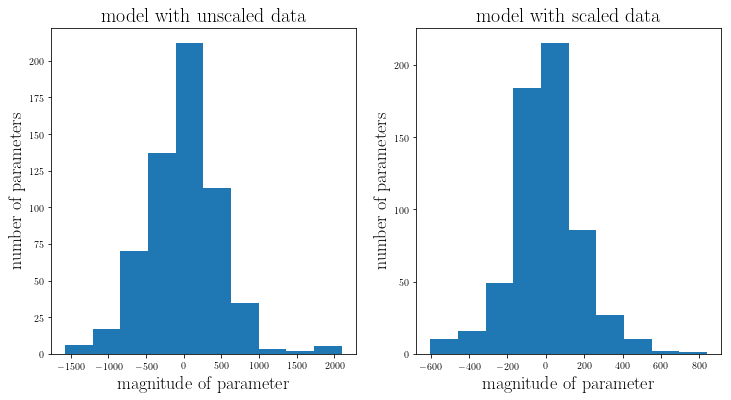

In [38]:
print('The model using unscaled data has {} coefficients.'.format(model_KRR_unscaled.dual_coef_.size))

fig, ax = plt.subplots(1, 2, figsize=(12, 6))
ax[0].hist(model_KRR_unscaled.dual_coef_)
ax[0].set_xlabel("magnitude of parameter")
ax[0].set_ylabel("number of parameters")
ax[0].set_title("model with unscaled data")
print('The largest coefficient is {:.3f}.'.format(max(abs(model_KRR_unscaled.dual_coef_))[0]));
KRR_largest_coef=max(abs(model_KRR_unscaled.dual_coef_))[0]

print('The model using scaled data has {} coefficients.'.format(model_KRR_scaled.dual_coef_.size))

ax[1].hist(model_KRR_scaled.dual_coef_)
ax[1].set_xlabel("magnitude of parameter")
ax[1].set_ylabel("number of parameters")
ax[1].set_title("model with scaled data")
print('The largest coefficient is {:.3f}.'.format(max(abs(model_KRR_scaled.dual_coef_))[0]))
KRR_largest_coef_scaled=max(abs(model_KRR_scaled.dual_coef_))[0]

The coefficients are normally distributed for two models. The values of coefficients in KRR models, which include regularization terms in the loss function, are in a reasonable range. One thing to notice is that the size of the coefficients is one order of magnitude smaller after scaling the data by comparing the largest coefficient in the model. This indicates that KRR using scaled data is more likely to be not overfitted with high accuracy.

## LASSO-multi-linear regression: dropping features
When the tolerance of training process is set to a bigger value (from 0.01 to 1), the LASSO-multi-linear regression model gives an interesting result: it drops most features while keeping a relatively good accuracy ($r^2 > 0.9$).

In [39]:
alphas = np.array([1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 10, 100])

model_LASSO_MLR_unscaled = LASSO(X_train_test, y_train_test, alphas, tol=1)
r2_LASSO_MLR_unscaled_Validation = model_LASSO_MLR_unscaled.score(X_validation, y_validation)
y_pred_LASSO_MLR_unscaled = model_LASSO_MLR_unscaled.predict(X_validation)
print('{:<30}{:<15}r^2 = {:.3f}'.format("LASSO-Multi-linear regression", "unscaled data", r2_LASSO_MLR_unscaled_Validation))
print('{:<30}number of nonzero coefficients: {}'.format("", model_LASSO_MLR_unscaled.coef_[~np.isclose(model_LASSO_MLR_unscaled.coef_, 0)].size))
print('{:<30}nonzero coefficients: {}'.format("", model_LASSO_MLR_unscaled.coef_[~np.isclose(model_LASSO_MLR_unscaled.coef_, 0)]))

model_LASSO_MLR_scaled = LASSO(X_train_test_scaled, y_train_test, alphas, tol=1)
r2_LASSO_MLR_scaled_Validation = model_LASSO_MLR_scaled.score(X_validation_scaled, y_validation)
y_pred_LASSO_MLR_scaled = model_LASSO_MLR_scaled.predict(X_validation_scaled)
print('\n{:<30}{:<15}r^2 = {:.3f}'.format("LASSO-Multi-linear regression", "scaled data", r2_LASSO_MLR_scaled_Validation))
print('{:<30}number of nonzero coefficients: {}'.format("", model_LASSO_MLR_scaled.coef_[~np.isclose(model_LASSO_MLR_scaled.coef_, 0)].size))
print('{:<30}nonzero coefficients: {}'.format("", model_LASSO_MLR_scaled.coef_[~np.isclose(model_LASSO_MLR_scaled.coef_, 0)]))

LASSO-Multi-linear regression unscaled data  r^2 = 0.971
                              number of nonzero coefficients: 7
                              nonzero coefficients: [-1.76306354e-03 -1.09812111e-03 -4.54468513e-04  5.17274966e-04
  1.02420870e-03  1.75474598e-03  9.36141367e-01]

LASSO-Multi-linear regression scaled data    r^2 = 0.906
                              number of nonzero coefficients: 3
                              nonzero coefficients: [1.6117245  0.27379556 2.20555285]


# Reference
Agrawal, Mayank, and David S. Sholl. "Effects of Intrinsic Flexibility on Adsorption Properties of Metal–Organic Frameworks at Dilute and Nondilute Loadings." *ACS applied materials & interfaces* 11.34 (2019): 31060-31068.